In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ruptures.detection import Pelt
import ruptures as rpt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Data Exploration

In [6]:
# Load data
data = pd.read_csv('..\data\BrentOilPrices.csv', parse_dates=['Date'], dayfirst=True)

In [7]:
# Display first few rows
data.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [8]:
# Check for missing values
data.isnull().sum()

Date     0
Price    0
dtype: int64

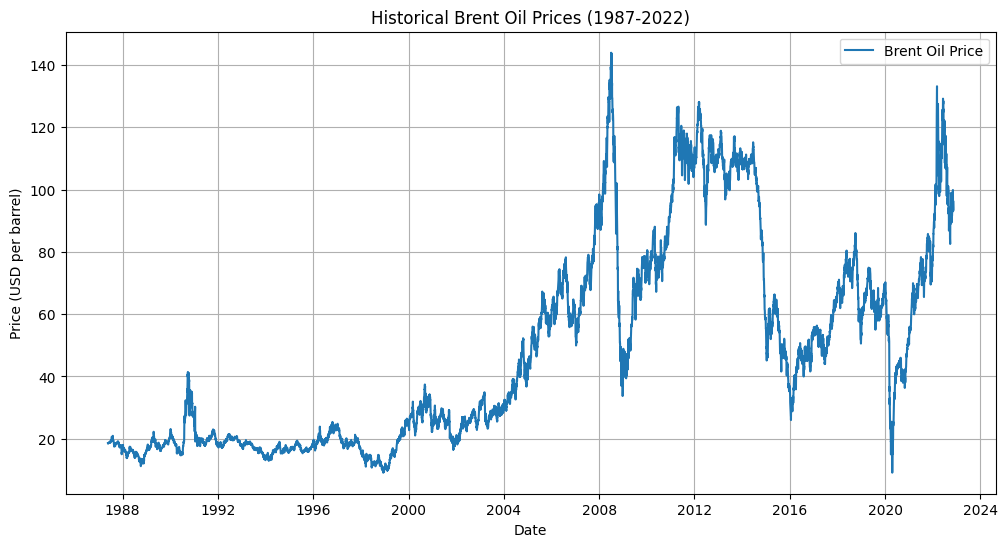

In [9]:
# Plot historical prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'], label='Brent Oil Price')
plt.title('Historical Brent Oil Prices (1987-2022)')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.grid()
plt.show()

# Change Point Analysis

In [12]:
# Convert prices to numpy array
prices = data['Price'].values

In [13]:
# Detect change points
algo = rpt.Pelt(model="rbf").fit(prices)
change_points = algo.predict(pen=10)  # Adjust penalty parameter as needed

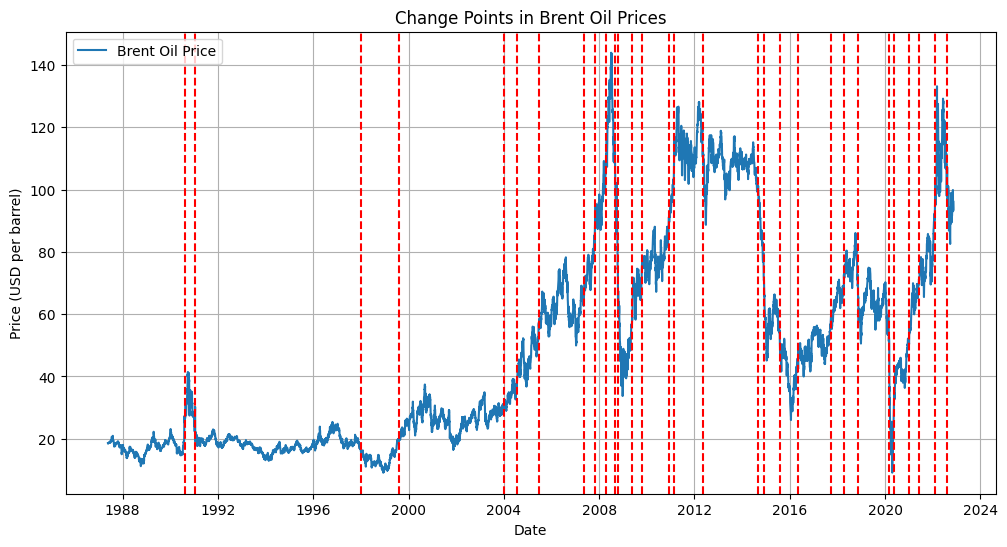

In [14]:
# Plot change points
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], prices, label='Brent Oil Price')
for cp in change_points[:-1]:  # Exclude the last change point
    plt.axvline(x=data['Date'].iloc[cp], color='r', linestyle='--')
plt.title('Change Points in Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD per barrel)')
plt.legend()
plt.grid()
plt.show()

# Time Series Modeling

In [18]:
# Fit ARIMA model
model_arima = ARIMA(data['Price'], order=(5, 1, 0))  # Adjust order as needed
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 9011
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -14540.613
Date:                Thu, 20 Feb 2025   AIC                          29093.226
Time:                        17:58:54   BIC                          29135.862
Sample:                             0   HQIC                         29107.733
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0260      0.006      4.344      0.000       0.014       0.038
ar.L2         -0.0235      0.006     -4.231      0.000      -0.034      -0.013
ar.L3         -0.0071      0.005     -1.507      0.1

In [19]:
# Fit GARCH model
model_garch = arch_model(data['Price'], vol='Garch', p=1, q=1)  # Adjust p and q as needed
results_garch = model_garch.fit()
print(results_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 97378349170.75806
Iteration:      2,   Func. Count:     12,   Neg. LLF: 70149.2042068351
Iteration:      3,   Func. Count:     19,   Neg. LLF: 1851811015.0339441
Iteration:      4,   Func. Count:     27,   Neg. LLF: 44034.729057607685
Iteration:      5,   Func. Count:     33,   Neg. LLF: 43698.83708600999
Iteration:      6,   Func. Count:     39,   Neg. LLF: 46134.33970540376
Iteration:      7,   Func. Count:     45,   Neg. LLF: 39816.66774832398
Iteration:      8,   Func. Count:     51,   Neg. LLF: 42848.420329461354
Iteration:      9,   Func. Count:     57,   Neg. LLF: 35637.13926185758
Iteration:     10,   Func. Count:     62,   Neg. LLF: 41279.10043111231
Iteration:     11,   Func. Count:     68,   Neg. LLF: 39707.41740071211
Iteration:     12,   Func. Count:     77,   Neg. LLF: 35582.89771940086
Iteration:     13,   Func. Count:     83,   Neg. LLF: 35540.59359118322
Iteration:     14,   Func. Count:     89,   Neg. LLF: 35231.00

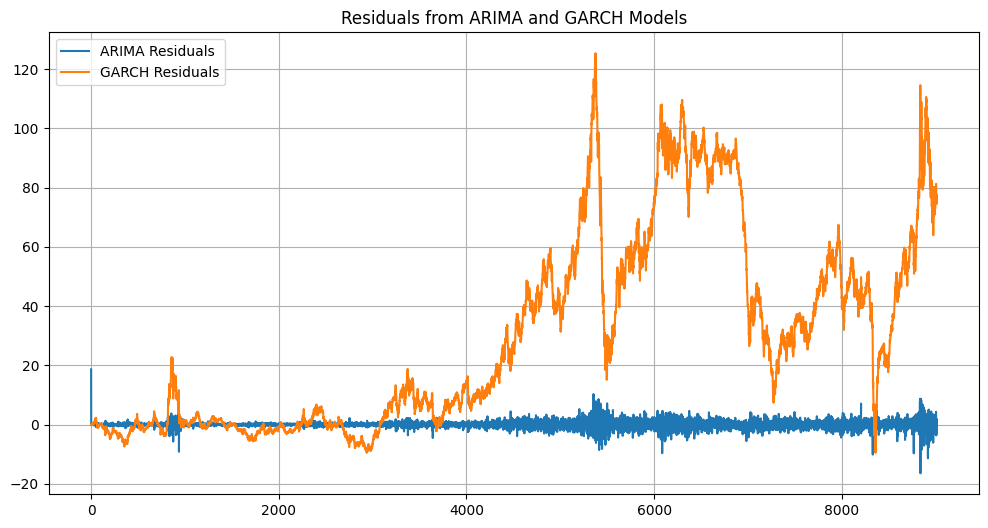

In [20]:
# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(results_arima.resid, label='ARIMA Residuals')
plt.plot(results_garch.resid, label='GARCH Residuals')
plt.title('Residuals from ARIMA and GARCH Models')
plt.legend()
plt.grid()
plt.show()